# Analysis of time-to-resolve Get It Done San Diego requests
## Notebook 4a: Machine Learning (Part 1)
### Choosing between models
After cleaning the Get It Done dataset and doing some preliminary EDA, I now want to be able to predict how long it will take to close any given request. After initial OOB tests with various types of prediction methods, Random Forest Classifiers and Random Forest Regressors emerged as the most promising model types (methods tried but not shown in this notebook: linear regression, logistic regression, Gradient Boost trees, ADA Boost trees, Naive Bayes classifiers).

This notebook will document: 1) processing steps taken to prepare the data to use in training and testing the two types of Random Forest models, and 2) a comparison of the performance of each model. The next notebook (4b - Machine Learning, Part 2) will show document hyperparameter tuning for the final selected model.

### 1 - Import libraries, import data and do some final cleaning

In [17]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
notebook_path = os.path.abspath("Notebook4a-Machine_Learning_Part1.ipynb")

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

#### *Discarding some requests* 
We will only use 'closed' requests because none of the other types (i.e. 'referred' or 'cancelled') have updated datetime information in the database. Almost all request types, from all sources (whether initiated by the public or city officials) are included in this model. The one exception is for 'Graffiti Removal' requests entered by City workers, because those requests are marked 'closed' as soon as they are entered into the database. My interpretation is that in this one case, City workers use the Get It Done database to log work that they've already completed, rather than to create records for work that needs to be done in the future.

In [18]:
filename_csv = os.path.join(os.path.dirname(notebook_path), "gid_with_demo.csv")
gid_with_demo = pd.read_csv(filename_csv, index_col=0)
gid_with_demo.set_index('service_request_id', inplace=True)
predictor_df = gid_with_demo.copy()

# Only use closed requests
predictor_df = predictor_df[predictor_df.status=='Closed']

# Remove Crew/Self Generated Graffiti Removal requests
predictor_df = predictor_df.drop(predictor_df[(predictor_df.case_origin == 'Crew/Self Generated') & 
                             (predictor_df.service_name == 'Graffiti Removal')].index)

# Drop all unneeded columns
predictor_df = predictor_df.drop(columns=['requested_datetime','updated_datetime','status',
                                          'lat','long','datetime_till_closed','resolved',
                                          'zipcode','housing_value','median_age'],axis=1)

# Get rid of any NaN values that may have slipped through
predictor_df = predictor_df.dropna(axis=0, how='any', subset=['service_name','case_record_type',
                                          'district','case_origin','days_till_closed','load_by_service',
                                          'load_by_service_zip','household_income','pop_density'])

### 2 - Preparation for model training

#### *Add a column ('closed_bin') to use as labels for the classifier model*
This column will be used for the multi-class model, but not for the regression model. It's easier to add it to the dataframe here before normalization and splitting into test and training sets.

In [19]:
predictor_df['closed_bin'] = ''
predictor_df.loc[(predictor_df.days_till_closed < 6), 'closed_bin'] = 0
predictor_df.loc[((predictor_df.days_till_closed >= 6) & 
                  (predictor_df.days_till_closed < 31)), 'closed_bin'] = 1
predictor_df.loc[((predictor_df.days_till_closed >= 31) & 
                  (predictor_df.days_till_closed < 61)), 'closed_bin'] = 2
predictor_df.loc[(predictor_df.days_till_closed >= 61), 'closed_bin'] = 3

#### *Get dummy variables for categorical values*

In [20]:
predictor_df = pd.get_dummies(predictor_df, prefix=['service_name','case_record_type','district','case_origin'], 
                              columns=['service_name','case_record_type','district','case_origin'])

#### *Separate the training and test sets*
This is done *before* upsampling. We'll upsample the training set only so there is no 'bleed' through to the test set; in other words, no chance that the same record appears in both the training and testing set. I'm doing the train-test split manually below instead of using the sci-kit learn function, and *then* will separate into X and y sets.

In [21]:
import random

split = 0.75 # save 25% of data for test set
train = pd.DataFrame()
test = pd.DataFrame()
indices = np.array(range(len(predictor_df)))
random.Random(7).shuffle(indices)    # Random(XX) is the random seed for reproducibility
split_idx = int(len(indices) * split)
train = predictor_df.iloc[indices[:split_idx+1]]
test = predictor_df.iloc[indices[split_idx+1:]]

#### *Upsample the training data*

In [22]:
# Separate majority and minority classes
train_bin0 = train[train.closed_bin==0]
train_bin1 = train[train.closed_bin==1]
train_bin2 = train[train.closed_bin==2]
train_bin3 = train[train.closed_bin==3]

# Upsample minority classes
n_majority = len(train[train.closed_bin==0])
train_bin1_upsampled = resample(train_bin1,
                                  replace=True,          # sample with replacement
                                  n_samples=n_majority,  # to match majority class
                                  random_state=123)      # for reproducibility

train_bin2_upsampled = resample(train_bin2, replace=True, n_samples=n_majority, random_state=123)
train_bin3_upsampled = resample(train_bin3, replace=True, n_samples=n_majority, random_state=123)

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_bin0, train_bin1_upsampled, train_bin2_upsampled, 
                                 train_bin3_upsampled])

print(train.closed_bin.value_counts())
print(train_upsampled.closed_bin.value_counts())

1    53128
0    46839
3    22310
2    12583
Name: closed_bin, dtype: int64
3    46839
2    46839
1    46839
0    46839
Name: closed_bin, dtype: int64


### 3 - Regressors (linear regression and random forest regressor)
This section will try models that directly predict how many days it will take to close a request (rather than what closure category a request falls into)

#### *Create X and y datasets*

In [23]:
X_train = train_upsampled.copy()

# scale the predictor data
rbscaler = RobustScaler()
X_train[['household_income','pop_density','load_by_service','load_by_service_zip']] = \
rbscaler.fit_transform(X_train[['household_income','pop_density','load_by_service','load_by_service_zip']])

X_train = X_train.drop(columns=['days_till_closed', 'closed_bin'], axis=1).values
y_train = train_upsampled['days_till_closed'].values


X_test = test.copy()
X_test = X_test.drop(columns=['days_till_closed', 'closed_bin'], axis=1).values
y_test = test['days_till_closed'].values

#### *Linear regression*

Training set R^2: 0.41737998683779753
Test set R^2: -4.356769003226514e+17


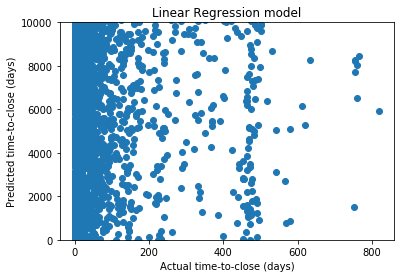

In [29]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

# Fit the regressor to the training data
lin_reg.fit(X_train, y_train)

print("Training set R^2:", lin_reg.score(X_train, y_train))
print("Test set R^2:", lin_reg.score(X_test, y_test))

# Predict on the test data: y_pred
y_pred = lin_reg.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual time-to-close (days)')
plt.ylabel('Predicted time-to-close (days)')
plt.ylim([0, 10000])
plt.title('Linear Regression model')
plt.show()

#### *Random Forest Regressor*

Training set R^2: 0.9710766388008418
Test set R^2: -0.13992848389013424


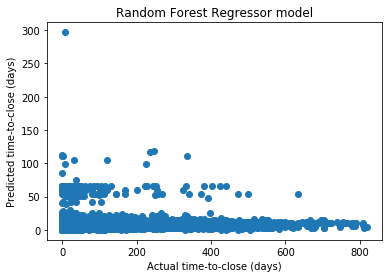

In [25]:
rf_regr = RandomForestRegressor()

# Fit the regressor to the training data
rf_regr.fit(X_train, y_train)

print("Training set R^2:", rf_regr.score(X_train, y_train))
print("Test set R^2:", rf_regr.score(X_test, y_test))

# Predict the labels of the test set: y_pred
y_pred = rf_regr.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('Actual time-to-close (days)')
plt.ylabel('Predicted time-to-close (days)')
plt.title('Random Forest Regressor model')
plt.show()

### 4 - Multilabel Classifiers

#### *Create X and y datasets*

In [10]:
X_train = train_upsampled.copy()
X_train = X_train.drop(columns=['days_till_closed', 'closed_bin'], axis=1).values
y_train = train_upsampled['closed_bin'].values

X_test = test.copy()
X_test = X_test.drop(columns=['days_till_closed', 'closed_bin'], axis=1).values
y_test = test['closed_bin'].values

#### *Logistic regression*

In [11]:
from sklearn.linear_model import LogisticRegressionCV 

logr = LogisticRegressionCV(multi_class='multinomial')
logr.fit(X_train, y_train)

# Predicting the Test set results
y_pred = logr.predict(X_test)

# Making the Confusion Matrix
print("Logistic Regression\n")
print(pd.crosstab(y_test, y_pred, rownames=['Actual Bin'],
                  colnames=['Predicted Bin'], normalize='index'))
print("Training set accuracy:", logr.score(X_train, y_train))
print("Test set accuracy:", logr.score(X_test, y_test))
print('Test set f1 score:', f1_score(y_test, y_pred, average='macro'))

Logistic Regression

Predicted Bin         0         1         2         3
Actual Bin                                           
0              0.239449  0.206941  0.058101  0.495508
1              0.127059  0.245882  0.057881  0.569179
2              0.126306  0.088900  0.106388  0.678407
3              0.079648  0.011359  0.148884  0.760108
Training set accuracy: 0.3339364632037405
Test set accuracy: 0.31548506217605055
Test set f1 score: 0.27914048710823564


#### *Random Forest Classifier*

In [12]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Predicting the Test set results
y_pred = rf_clf.predict(X_test)

# Making the Confusion Matrix
print("Random Forest Classifier\n")
print(pd.crosstab(y_test, y_pred, rownames=['Actual Bin'],
                  colnames=['Predicted Bin'], normalize='index'))
print("Training set accuracy:", rf_clf.score(X_train, y_train))
print("Test set accuracy:", rf_clf.score(X_test, y_test))
print('Test set f1 score:', f1_score(y_test, y_pred, average='macro'))

Random Forest Classifier

Predicted Bin         0         1         2         3
Actual Bin                                           
0              0.705099  0.178569  0.052155  0.064176
1              0.282892  0.478851  0.115984  0.122273
2              0.189944  0.278844  0.320136  0.211076
3              0.153753  0.198648  0.136849  0.510751
Training set accuracy: 0.9870727385298576
Test set accuracy: 0.5474384356995083
Test set f1 score: 0.49259859677591167


#### *Naive Bayes*

In [13]:
from sklearn.naive_bayes import BernoulliNB

nb_bern = BernoulliNB()
nb_bern.fit(X_train, y_train)

# Predicting the Test set results
y_pred = nb_bern.predict(X_test)

# Making the Confusion Matrix
print("Naive Bayes Classifier\n")
print(pd.crosstab(y_test, y_pred, rownames=['Actual Bin'],
                  colnames=['Predicted Bin'], normalize='index'))
print("Training set accuracy:", nb_bern.score(X_train, y_train))
print("Test set accuracy:", nb_bern.score(X_test, y_test))
print('Test set f1 score:', f1_score(y_test, y_pred, average='macro'))

Naive Bayes Classifier

Predicted Bin         0         1         2         3
Actual Bin                                           
0              0.598850  0.163446  0.116590  0.121114
1              0.251113  0.289682  0.258849  0.200356
2              0.219820  0.100802  0.404421  0.274957
3              0.159838  0.044219  0.252197  0.543746
Training set accuracy: 0.45704434338905614
Test set accuracy: 0.44840166396013614
Test set f1 score: 0.4168474782498245


#### *Gradient Boosted Tree*

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gboost = GradientBoostingClassifier()
gboost.fit(X_train, y_train)

# Predicting the Test set results
y_pred = gboost.predict(X_test)

# Making the Confusion Matrix
print("Gradient Boost Classifier\n")
print(pd.crosstab(y_test, y_pred, rownames=['Actual Bin'],
                  colnames=['Predicted Bin'], normalize='index'))
print("Training set accuracy:", gboost.score(X_train, y_train))
print("Test set accuracy:", gboost.score(X_test, y_test))
print('Test set f1 score:', f1_score(y_test, y_pred, average='macro'))

Naive Bayes Classifier

Predicted Bin         0         1         2         3
Actual Bin                                           
0              0.491631  0.210431  0.172106  0.125832
1              0.079363  0.456756  0.293355  0.170525
2              0.051737  0.174156  0.533884  0.240223
3              0.031373  0.086951  0.322786  0.558891
Training set accuracy: 0.5157614381178078
Test set accuracy: 0.4926256312148244
Test set f1 score: 0.4696668740819283


#### *ADA-boosted tree*

In [15]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)

# Predicting the Test set results
y_pred = adaboost.predict(X_test)

# Making the Confusion Matrix
print("ADA Boost Classifier\n")
print(pd.crosstab(y_test, y_pred, rownames=['Actual Bin'],
                  colnames=['Predicted Bin'], normalize='index'))
print("Training set accuracy:", adaboost.score(X_train, y_train))
print("Test set accuracy:", adaboost.score(X_test, y_test))
print('Test set f1 score:', f1_score(y_test, y_pred, average='macro'))

Naive Bayes Classifier

Predicted Bin         0         1         2         3
Actual Bin                                           
0              0.446326  0.222258  0.231629  0.099787
1              0.060719  0.387578  0.379675  0.172028
2              0.059752  0.139179  0.471217  0.329852
3              0.039621  0.074239  0.311291  0.574848
Training set accuracy: 0.46894148039027306
Test set accuracy: 0.44626610014904455
Test set f1 score: 0.4340749881919536
